# Dataset bias analysis

We compute the class balance for different subsets of our training dataset to see if the dataset holds any bias
that may lead to model overgeneralization.

## Downloading and preprocessing data

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import urllib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
# ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 


# def download_file(url, fname):
#     urllib.request.urlretrieve(url, fname)


# download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
# download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

# TODO(jetpack): not working... "AttributeError: 'module' object has no attribute 'request'"

COMMENTS = '../data/toxicity_annotated_comments.tsv'
ANNOTATIONS = '../data/toxicity_annotations.tsv'

In [3]:
comments = pd.read_csv(COMMENTS, sep='\t', index_col=0)
annotations = pd.read_csv(ANNOTATIONS, sep='\t')

In [47]:
# label a comment as toxic if the majority of annotators did so
comments['toxic'] = annotations.groupby('rev_id')['toxicity'].mean() > 0.5
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
comments['length'] = comments['comment'].str.len()

In [50]:
train_comments = comments.query('split == "train"')

## Examining dataset bias

We look at the class balance of different subsets of the training data.

In [7]:
def filter_frame(frame, keyword=None, length=None):
    """Filters DataFrame to comments that contain the keyword as a substring and fit within length."""
    if keyword:
        frame = frame[frame['comment'].str.contains(keyword, case=False)]
    if length:
        frame = frame[frame['length'] <= length]
    return frame

def class_balance(frame, keyword, length=None):
    """Returns the fraction of the dataset labeled toxic."""
    frame = filter_frame(frame, keyword, length)
    return len(frame.query('toxic')) / len(frame)

In [8]:
print('overall fraction of comments labeled toxic:', class_balance(train_comments, keyword=None))

overall fraction of comments labeled toxic: 0.0966120469841


In [9]:
print('overall fraction of comments containing "gay" labeled toxic:', class_balance(train_comments, keyword='gay'))

overall fraction of comments containing "gay" labeled toxic: 0.550156739812


We see that of comments containing the string "gay", 55% are labeled toxic, compared to 9.6% for the overall dataset. Let's check a few other terms.

In [10]:
TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

print('overall class balance        {:.1f}%\t{} examples'.format(
    100 * class_balance(train_comments, keyword=None), len(train_comments)))

for fraction, num, term in sorted((class_balance(train_comments, term),
                                   len(filter_frame(train_comments, term)),
                                   term)
                                  for term in TEST_TERMS):
    print('class balance for {:10s} {:.1f}%\t{} examples'.format(term, 100 * fraction, num))

# for term in TEST_TERMS:
#     print('class balance for {:10s} {:.1f}%\t{} examples'.format(
#         term, 100 * class_balance(train_comments, keyword=term), len(filter_frame(train_comments, keyword=term))))

overall class balance        9.7%	95692 examples
class balance for box        2.7%	2997 examples
class balance for music      4.6%	928 examples
class balance for bisexual   6.9%	29 examples
class balance for tall       7.1%	1400 examples
class balance for wikipedia  7.3%	16821 examples
class balance for heterosexual 7.4%	27 examples
class balance for christian  7.6%	686 examples
class balance for jewish     8.7%	438 examples
class balance for straight   9.7%	424 examples
class balance for muslim     11.1%	467 examples
class balance for teacher    11.4%	176 examples
class balance for feminist   12.0%	50 examples
class balance for white      12.0%	938 examples
class balance for black      12.4%	871 examples
class balance for transgender 16.7%	24 examples
class balance for jew        17.4%	913 examples
class balance for lesbian    30.0%	50 examples
class balance for homosexual 38.9%	216 examples
class balance for gay        55.0%	638 examples
class balance for queer      57.4%	61 examples

In [11]:
train_comments.length.describe(percentiles=[.5, .9, .95, .99])

count    95692.000000
mean       401.608818
std        598.384488
min          5.000000
50%        211.000000
90%        898.000000
95%       1380.000000
99%       3503.270000
max       5900.000000
Name: length, dtype: float64

In [12]:
def toxicity_histogram_by_length(frame, keyword=None, xbound=2000, num_bins=100, **hist_kwargs):
    """Plots comment length histogram for toxic and non-toxic comments."""
    if keyword:
        frame = filter_frame(frame, keyword)

    # Plot.
    bin_range = range(0, xbound, xbound//num_bins)
    _fig, ax = plt.subplots()
    # This simulates a stacked plot by plotting all data first, and then plotting 
    # the toxic counts on top. The un-covered portion is the not-toxic count.
    ax.hist(frame['length'].values,
            bins=bin_range, label='not-toxic', color='lightgreen', **hist_kwargs)
    ax.hist(frame[frame['toxic'] == True]['length'].values,
            bins=bin_range, label='toxic', color='red', **hist_kwargs)

    # Decorate.
    ax.legend()
    ax.set_xlabel('comment length')
    ax.set_ylabel('# comments')
    title = 'length distribution'
    if keyword:
        title += ' containing ' + keyword
    ax.set_title(title)
    plt.show()
    
def toxicity_ratio_by_length(frame, keyword=None, xbound=2000, num_bins=50):
    if keyword:
        frame = filter_frame(frame, keyword)

    # Compute toxicity ratio.
    frame = frame.copy()
    frame['lenbin'] = pd.cut(frame['length'], bins=range(0, xbound, xbound//num_bins))
    frame = frame.groupby(['lenbin', 'toxic']).size().unstack('toxic').fillna(0)
    frame['toxratio'] = frame[True] / (frame[True] + frame[False])

    ax = frame.toxratio.plot()
    ax.set_xlabel('comment length'); ax.set_ylabel('toxicity ratio')
    ax.set_ybound((0, 1))
    title = 'toxicity ratio'
    if keyword:
        title += ' containing ' + keyword

    ax.set_title(title)
    plt.show()

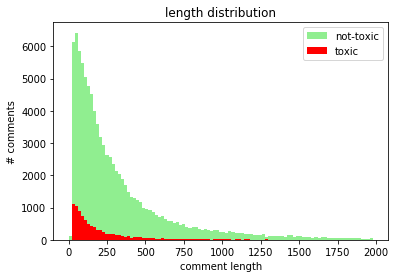

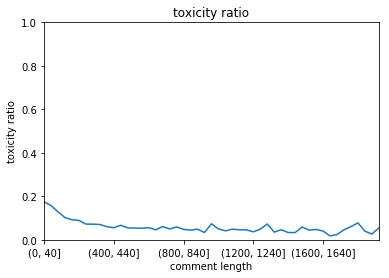

In [13]:
toxicity_histogram_by_length(train_comments), toxicity_ratio_by_length(train_comments);

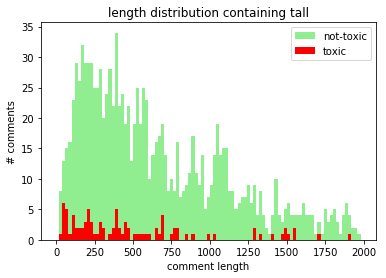

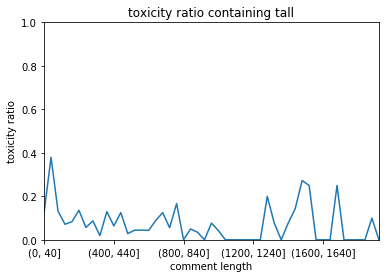

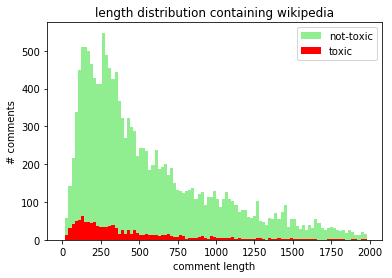

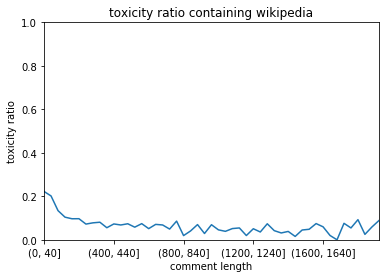

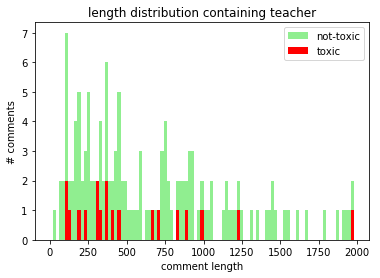

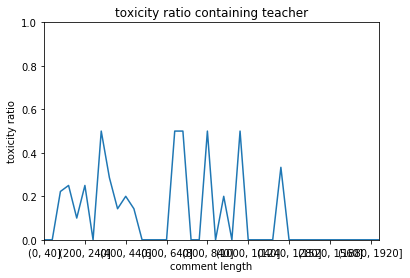

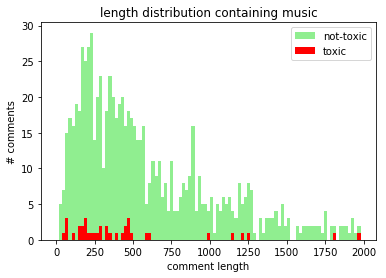

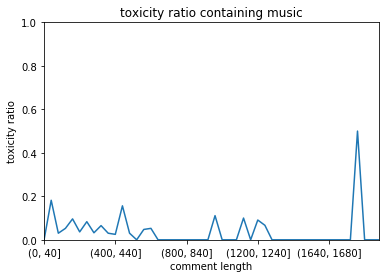

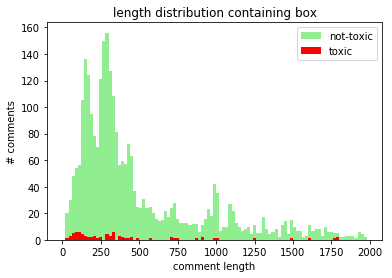

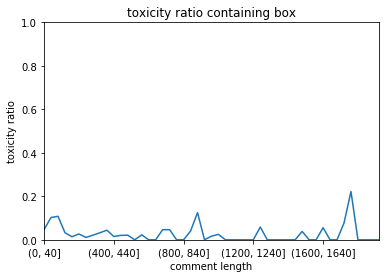

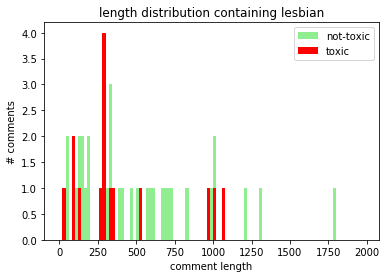

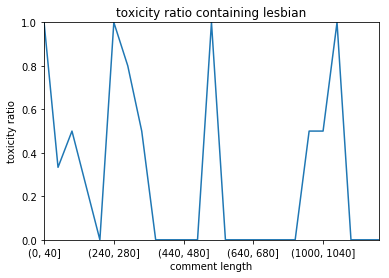

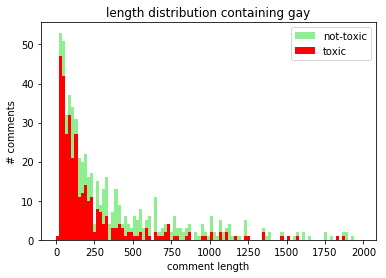

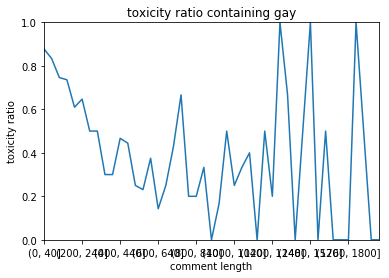

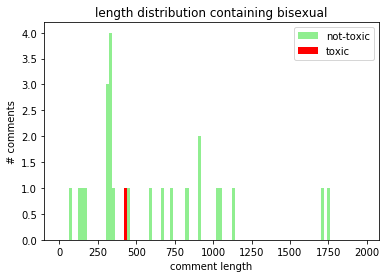

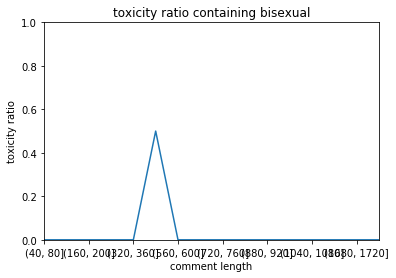

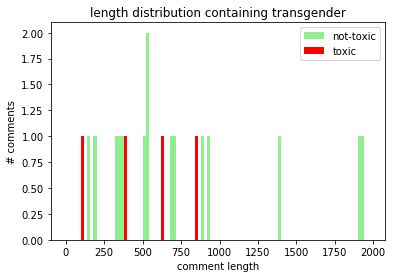

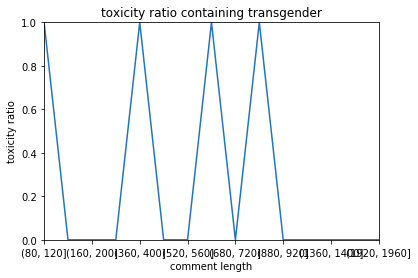

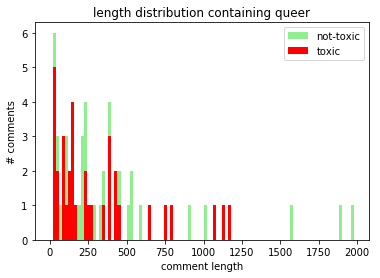

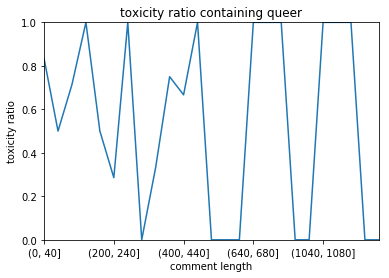

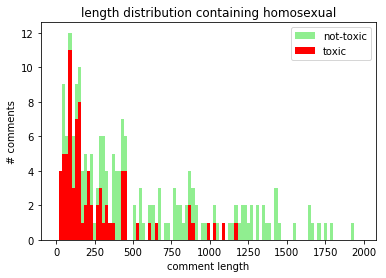

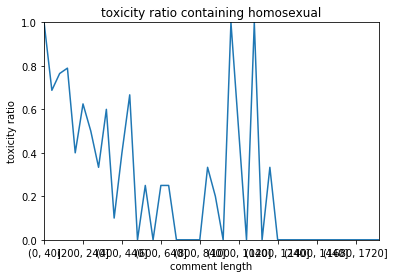

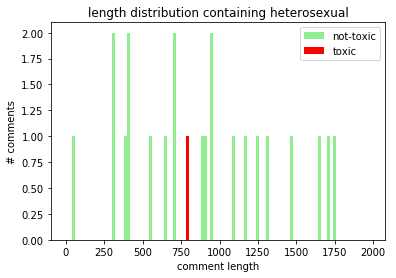

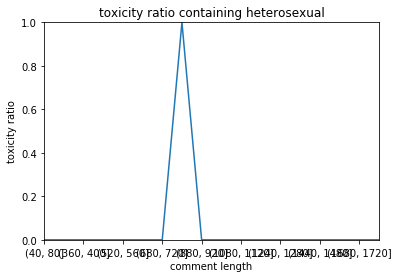

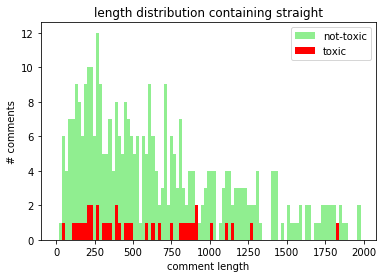

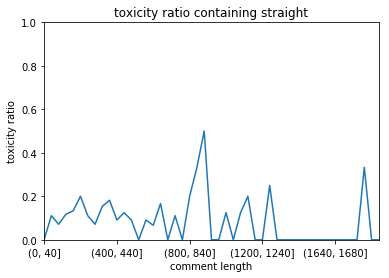

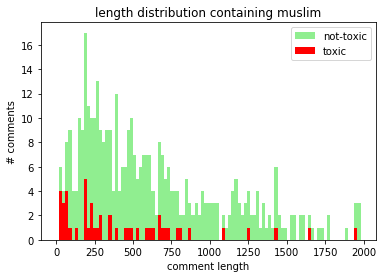

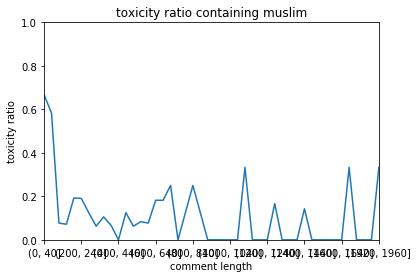

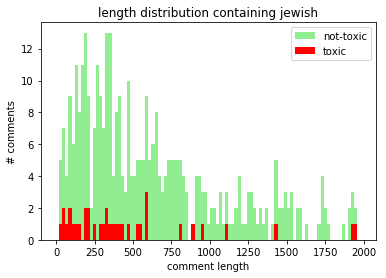

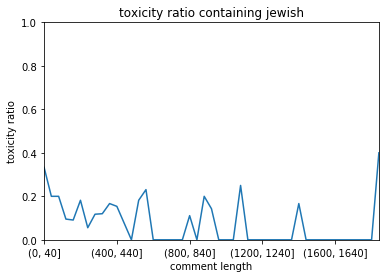

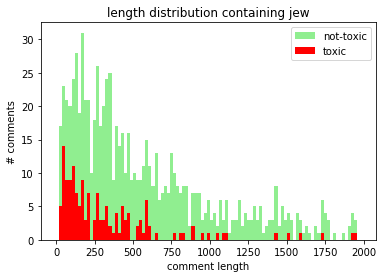

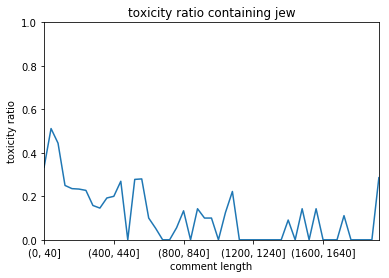

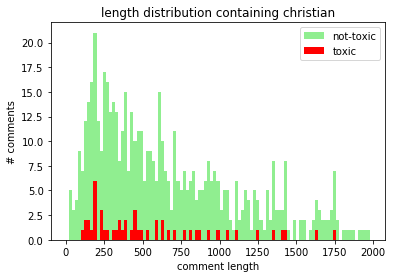

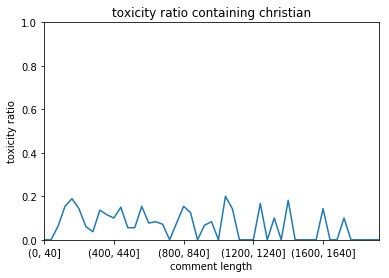

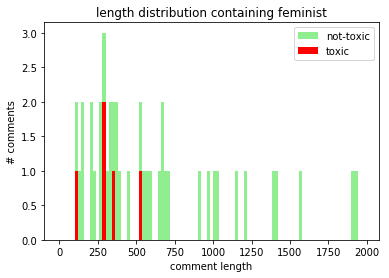

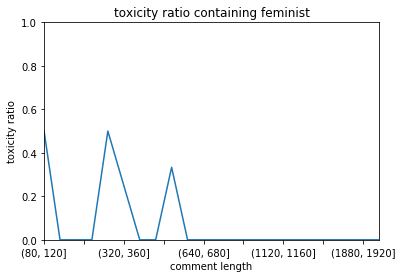

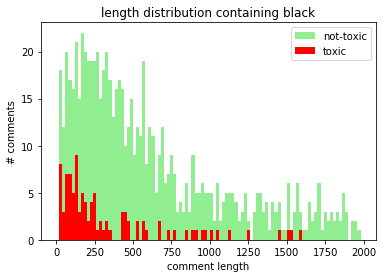

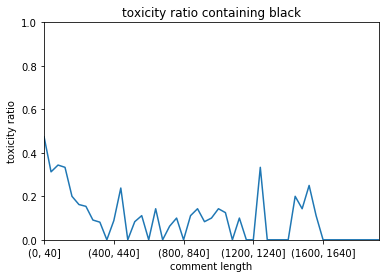

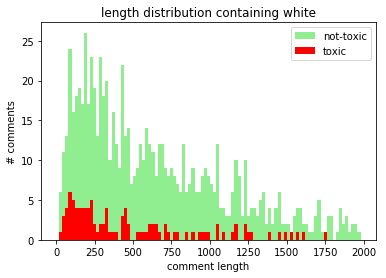

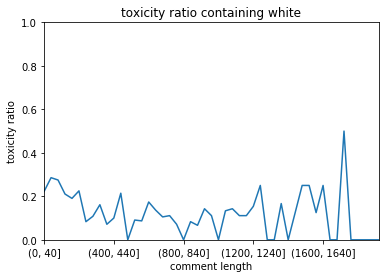

In [14]:
for term in TEST_TERMS:
    toxicity_histogram_by_length(train_comments, keyword=term)
    toxicity_ratio_by_length(train_comments, keyword=term)

From these plots, we see that "gay" has the most obvious problem, as there is a significant amount of data, and much of it is toxic, especially for shorter comments. We also see that the balance for "jew", "queer", "muslim", and "black" are also elevated compared to the overall distribution, especially for very short comments.

The balance for "transgender", "queer", and "lesbian" is also skewed, but there is relatively little data for these terms.

In [15]:
for fraction, term in sorted((class_balance(train_comments, term, length=150), term)
                              for term in TEST_TERMS):
    print('class balance for short comments containing {:10s} {:.1f}%'.format(term, 100 * fraction))

class balance for short comments containing bisexual   0.0%
class balance for short comments containing heterosexual 0.0%
class balance for short comments containing box        6.7%
class balance for short comments containing straight   7.7%
class balance for short comments containing music      7.9%
class balance for short comments containing christian  9.8%
class balance for short comments containing wikipedia  14.1%
class balance for short comments containing tall       16.9%
class balance for short comments containing jewish     17.4%
class balance for short comments containing teacher    18.8%
class balance for short comments containing feminist   20.0%
class balance for short comments containing white      27.7%
class balance for short comments containing muslim     32.5%
class balance for short comments containing black      36.0%
class balance for short comments containing jew        39.9%
class balance for short comments containing lesbian    40.0%
class balance for short comm

## Computing the non-toxic deficit

We compute the "deficit" of non-toxic comments for the terms for which we would like to mitigate bias.

TODO(jetpack): link to README docs or model bias eval notebook where we see worse performance for these terms.

Let $f$ be the desired non-toxic fraction, $n$ be the current number of non-toxic examples, and $t$ be the current number of toxic examples. $a$ is the number of non-toxic examples we need to add in order for the non-toxic fraction to equal $f$.

$$\frac{n + a}{t + n + a} = f$$
$$n + a = f(t + n) + fa$$
$$a - fa = f(t + n) - n$$
$$a(1 - f) = f(t + n) - n$$
$$a = \frac{f(t + n) - n}{1 - f}$$

In [188]:
# TODO(jetpack): it feels like this code shouldn't need to be this complicated.

import copy
import re
from collections import OrderedDict
from collections import defaultdict
from IPython import display


class TermDeficits(object):
    """Keeps track of the per-length deficit for a single term."""
    def __init__(self, term):
        self._term = term
        self._length_deficits = []

    def add_length_deficit(self, len_low, len_high, deficit):
        self._length_deficits.append({'len_low': len_low, 'len_high': len_high, 'deficit': deficit})

    def total_deficit(self):
        return sum(x['deficit'] for x in self._length_deficits)
  
    def has_deficit(self, length):
        for deficit in self._length_deficits:
            if deficit['len_low'] <= length and length < deficit['len_high']:
                return deficit['deficit'] > 0
        # print('text outside all length bounds?', length, self._length_deficits)
        return False
  
    def fill_deficit(self, length):
        for deficit in self._length_deficits:
            if deficit['len_low'] <= length and length < deficit['len_high']:
                deficit['deficit'] -= 1
                break
        else:
            # Didn't break: this shouldn't happen!
            print('asked to fill deficit with len {}, but outside our bounds!!'.format(length))

    def as_series(self):
        ds = OrderedDict()
        for len_def in sorted(self._length_deficits, key=lambda x: x['len_low']):
            ds['[{len_low},{len_high})'.format(**len_def)] = len_def['deficit']
        ds['(total)'] = self.total_deficit()
        return pd.Series(ds, name=self._term)

    def __repr__(self):
        def dict_repr(len_deficit):
            return 'LenDef([{len_low},{len_high}) => {deficit:6.1f})'.format(**len_deficit)
        len_defs = sorted(self._length_deficits, key=lambda len_def: len_def['len_low'])
        return 'TermDeficit({:10s}: {})'.format(self._term,
                                                '; '.join(map(dict_repr, len_defs)))
  
    def __deepcopy__(self, memo):
        copy_ = TermDeficits(self._term)
        copy_._length_deficits = copy.deepcopy(self._length_deficits, memo)
        return copy_


class Deficits(object):
    """Keeps track of the non-toxic deficits for a set of terms at specific length buckets."""

    def __init__(self, terms):
        """Construct a new Deficits manager for the given terms."""
        self._terms = terms
        # Used to determine if an example matches any term at all.
        self._terms_regex = re.compile('|'.join(terms), re.IGNORECASE)
        self._term_deficits = {term: TermDeficits(term) for term in terms}

    def add_deficit(self, term, length_low, length_high, deficit):
        self._term_deficits[term].add_length_deficit(length_low, length_high, deficit)

    def _term_matches(self, text):
        """Returns terms that are mentioned in the text (substring matching)."""
        # This is just for efficiency.
        if self._terms_regex.search(text) is None:
            return []
        ltext = text.lower()
        return [term for term in self._terms if term in ltext]
  
    def can_use_example(self, text):
        """If text can fill any remaining deficits, returns True and decrements all deficits
        that the text fills. Else, returns false."""
        # Does the text match any term?
        matched_terms = self._term_matches(text)
        if not matched_terms:
            return False

        # Do any of those terms have a deficit at this length?
        length = len(text)
        matched_term_deficits = [self._term_deficits[term] for term in matched_terms]
        if not any(term_deficit.has_deficit(length) for term_deficit in matched_term_deficits):
            return False
    
        # Decrement all matching term deficits.
        for term_def in matched_term_deficits:
            term_def.fill_deficit(length)
        return True
  
    def as_frame(self):
        df = pd.DataFrame(term_def.as_series() for term_def in self._term_deficits.itervalues())
        df = df.sort_values('(total)')
        return df    
  
    def __repr__(self):
        term_deficits = sorted(self._term_deficits.itervalues(), key=lambda td: td.total_deficit())
        return 'Deficits(\n  {}\n)'.format('\n  '.join(repr(val) for val in term_deficits))
  
    def _repr_html_(self):
        return self.as_frame()._repr_html_()
  
    def __deepcopy__(self, memo):
        copy_ = Deficits(self._terms)
        copy_._term_deficits = copy.deepcopy(self._term_deficits, memo)
        return copy_

    
# See derivation above.
def _nontoxic_deficit(target_nontox_ratio, current_nontoxic, current_toxic):
    current_total = current_nontoxic + current_toxic
    return ((target_nontox_ratio * current_total - current_nontoxic) /
            (1 - target_nontox_ratio))


# Note: To be more sophisticated, we could distinguish between inclusive and
# exclusive boundaries and adjust the values appropriately to fit with the usual
# '[lo,hi)' convention. But it doesn't really matter, so we don't bother.
def _parse_lenbin(lenbin_interval):
    """Returns lower and upper bound from lenbin string."""
    pat = r'([.0-9]+), ([.0-9]+)'
    lenbin_str = str(lenbin_interval)
    return [int(round(float(num))) for num in re.search(pat, lenbin_str).groups()]


def compute_nontox_deficits(frame, terms, quantiles=4, train_split=0.6):
    deficit_mult = 1 / train_split
    frame = frame.copy()
    lenbins, bins = pd.qcut(frame['length'], q=quantiles, retbins=True)

    frame['lenbin'] = lenbins
    bins = bins.astype(int)
    print('bins:', bins)

    overall = frame.copy()
    overall = overall.groupby(['lenbin', 'toxic']).size().unstack('toxic').fillna(0)
    overall['toxratio'] = overall[True] / (overall[True] + overall[False])
    print('overall tox ratios:')
    display.display(overall)

    deficits = Deficits(terms)
    for term in terms:
        term_frame = frame[frame['comment'].str.lower().str.contains(term)]
        term_frame = term_frame.groupby(['lenbin','toxic']).size().unstack('toxic').fillna(0)
        term_frame['toxratio'] = term_frame[True] / (
            term_frame[True] + term_frame[False])
        for lenbin, row in term_frame.iterrows():
            # print( 'lenbin:', lenbin, row)
            low, high = _parse_lenbin(lenbin)
            deficit = _nontoxic_deficit(
                target_nontox_ratio=1 - overall.loc[lenbin, 'toxratio'],
                current_nontoxic=row[False],
                current_toxic=row[True])
            deficits.add_deficit(term, low, high, deficit * deficit_mult)
            term_frame.loc[lenbin, 'deficit'] = deficit
        print('tox ratios for {}:'.format(term))
        display.display(term_frame)
    return deficits

In [189]:
DEBIAS_TERMS = ['queer', 'gay', 'homosexual', 'lesbian', 'transgender']

term_deficits = compute_nontox_deficits(train_comments, DEBIAS_TERMS, quantiles=5)
term_deficits

bins: [   5   82  159  281  536 5900]
overall tox ratios:


toxic,False,True,toxratio
lenbin,,,
"(4.999, 82.0]",16181,3156,0.163210
"(82.0, 159.0]",16814,2194,0.115425
"(159.0, 281.0]",17506,1640,0.085658
"(281.0, 536.0]",17848,1227,0.064325
"(536.0, 5900.0]",18098,1028,0.053749


tox ratios for queer:


toxic,False,True,toxratio,deficit
lenbin,,,,
"(4.999, 82.0]",3,7,0.700000,32.889417
"(82.0, 159.0]",2,10,0.833333,74.636281
"(159.0, 281.0]",6,5,0.454545,47.371951
"(281.0, 536.0]",6,7,0.538462,95.822331
"(536.0, 5900.0]",9,6,0.400000,96.630350


tox ratios for gay:


toxic,False,True,toxratio,deficit
lenbin,,,,
"(4.999, 82.0]",21,123,0.854167,609.628327
"(82.0, 159.0]",31,85,0.732759,620.408387
"(159.0, 281.0]",37,57,0.606383,571.440244
"(281.0, 536.0]",61,37,0.377551,477.203749
"(536.0, 5900.0]",137,49,0.263441,725.647860


tox ratios for homosexual:


toxic,False,True,toxratio,deficit
lenbin,,,,
"(4.999, 82.0]",5,15,0.750000,71.905894
"(82.0, 159.0]",8,28,0.777778,206.581586
"(159.0, 281.0]",11,11,0.500000,106.418293
"(281.0, 536.0]",29,17,0.369565,218.282804
"(536.0, 5900.0]",79,13,0.141304,149.865759


tox ratios for lesbian:


toxic,False,True,toxratio,deficit
lenbin,,,,
"(4.999, 82.0]",2,2,0.500000,8.254119
"(82.0, 159.0]",4,2,0.333333,11.327256
"(159.0, 281.0]",3,1,0.250000,7.674390
"(281.0, 536.0]",7,7,0.500000,94.822331
"(536.0, 5900.0]",19,3,0.136364,33.815175


tox ratios for transgender:


toxic,False,True,toxratio,deficit
lenbin,,,,
"(82.0, 159.0]",1.0,1.0,0.500000,6.663628
"(159.0, 281.0]",1.0,0.0,0.000000,-1.000000
"(281.0, 536.0]",5.0,1.0,0.166667,9.546047
"(536.0, 5900.0]",13.0,2.0,0.133333,22.210117


,(total),"[159,281)","[281,536)","[5,82)","[536,5900)","[82,159)"
transgender,62.366320,-1.666667,15.910079,NaN,37.016861,11.106047
lesbian,259.822119,12.790650,158.037218,13.756865,56.358625,18.878760
queer,578.917217,78.953252,159.703885,54.815695,161.050584,124.393801
homosexual,1255.090558,177.363821,363.804673,119.843156,249.776265,344.302644
gay,5007.214277,952.400407,795.339582,1016.047212,1209.413100,1034.013978


## Filling deficits with non-toxic data

TODO(jetpack): explain how we gathered this data

### Load data

In [142]:
WIKIPEDIA_SNIPPETS_PATH = '../data/wikipedia_article_snippets.json'

import json
import random

def _read_nontox_json(path):
    with open(path) as f:
        records = json.load(f)
        random.shuffle(records)
        return records

In [143]:
wiki_snippets = _read_nontox_json(WIKIPEDIA_SNIPPETS_PATH)

In [150]:
random.sample(wiki_snippets, 5)

[{u'id': u'wikipedia36534961_Conchita Wurst_4',
  u'text': u'Officials from the city\'s security department rejected the request, citing a wish to "respect morality in the education of the younger generation" and to prevent violent clashes between marchers and anti-gay demonstrators.'},
 {u'id': u'wikipedia148979_Queer theory_172',
  u'text': u"Perreau maintains that queer theory shows that being part of a group requires the ability to critique one's own belonging."},
 {u'id': u'wikipedia3587807_LGBT stereotypes_11',
  u'text': u'Theatre scholar Jordan Schildcrout has written about the recurrence of the "homicidal homosexual" in American plays, but notes that LGBT playwrights themselves have appropriated this negative stereotype to confront and subvert homophobia.'},
 {u'id': u'wikipedia35981740_LGBT culture in Liverpool_33',
  u'text': u'Indeed, the fear of prosecution under Section 28 had a direct impact on the city, when in 1988, Liverpool City Council chose to cancel a grant to a g

In [153]:
snippets_df = pd.DataFrame(wiki_snippets)

In [166]:
snippets_df.text.str.len().describe(percentiles=[0.5, 0.9, 0.99, 0.999])

count    116333.000000
mean        164.489595
std         101.975670
min           4.000000
50%         148.000000
90%         277.000000
99%         479.000000
99.9%       834.672000
max        6594.000000
Name: text, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39a8dd1810>]], dtype=object)

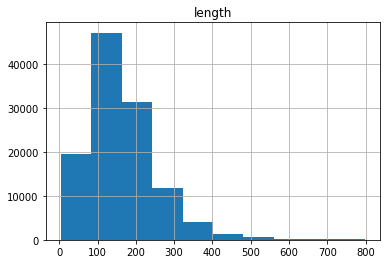

In [168]:
snippets_length = snippets_df.text.str.len().to_frame(name='length')
snippets_length.query('length < 800').hist()

### Filling deficits

In [186]:
# TODO: background gradient is per-column, *not* over the entire dataset.
# http://stackoverflow.com/questions/38931566/pandas-style-background-gradient-both-rows-and-colums
def fill_deficits(deficits, nontox_examples):
    deficits = copy.deepcopy(deficits)
    print('initial deficits:')
    #display.display(deficits)
    display.display(deficits.as_frame().style.background_gradient(cmap='viridis', low=0.8))
    examples_to_keep = []
    for example in nontox_examples:
        if deficits.can_use_example(example['text']):
            examples_to_keep.append(example)
    print('using {} of {} ({:.1f})%)'.format(len(examples_to_keep), len(nontox_examples),
                                             100 * len(examples_to_keep) / len(nontox_examples)))
    print('remaining deficits:')
    #display.display(deficits.as_frame().style.applymap(lambda x: '' if x > 0 else 'background-color: lightgreen'))
    display.display(deficits.as_frame().style.background_gradient(cmap='viridis', low=0.8))
    return examples_to_keep

In [190]:
nontox_keep = fill_deficits(term_deficits, wiki_snippets)

initial deficits:


,(total),"[159,281)","[281,536)","[5,82)","[536,5900)","[82,159)"
transgender,62.3663,-1.66667,15.9101,nan,37.0169,11.106
lesbian,259.822,12.7907,158.037,13.7569,56.3586,18.8788
queer,578.917,78.9533,159.704,54.8157,161.051,124.394
homosexual,1255.09,177.364,363.805,119.843,249.776,344.303
gay,5007.21,952.4,795.34,1016.05,1209.41,1034.01


asked to fill deficit with len 78, but outside our bounds!!
asked to fill deficit with len 73, but outside our bounds!!
asked to fill deficit with len 64, but outside our bounds!!
asked to fill deficit with len 75, but outside our bounds!!
asked to fill deficit with len 77, but outside our bounds!!
asked to fill deficit with len 43, but outside our bounds!!
asked to fill deficit with len 59, but outside our bounds!!
asked to fill deficit with len 79, but outside our bounds!!
using 5775 of 116333 (5.0)%)
remaining deficits:


,(total),"[159,281)","[281,536)","[5,82)","[536,5900)","[82,159)"
lesbian,-602.178,-166.209,-107.963,-77.2431,-86.6414,-164.121
transgender,-180.634,-52.6667,-70.0899,nan,-24.9831,-32.894
homosexual,68.0906,-24.6362,-1.19533,-0.156844,94.7763,-0.697356
queer,82.9172,-9.04675,-0.296115,-1.18431,96.0506,-2.6062
gay,660.214,-0.599593,-42.6604,-4.95279,731.413,-22.986


In [268]:
nontox_df = pd.DataFrame(nontox_keep)
nontox_df.rename(columns={'id': 'rev_id', 'text': 'comment'}, inplace=True)
nontox_df['is_toxic'] = False
nontox_df.head()

,rev_id,comment,is_toxic
0,wikipedia30730588_Jeanne Galzy_2,Jeunes Filles en serre chaude (1934) aimed to ...,False
1,wikipedia31925085_Pride Bristol_0,Pride Bristol organised its first events when ...,False
2,wikipedia158934_Catholic Church sexual abuse c...,"Additionally The New York Times reported ""the ...",False
3,wikipedia571061_Egan v Canada_0,"James Egan and John Norris Nesbit, the plainti...",False
4,wikipedia2388970_Elizabeth Mitchell_0,Mitchell had a recurring role as psychiatrist ...,False


In [269]:
len(nontox_df)

5775

In [270]:
def add_split_column(df, train_frac=0.6, test_frac=0.2):
    """Adds a 'split' column to the data frame, assigning "train", "dev", or "test" to each row randomly."""
    assert(train_frac + test_frac <= 1.0)
    train_num, test_num = [int(round(len(df) * frac)) for frac in train_frac, test_frac]
    
    train_items = df.index.isin(df.sample(train_num).index)
    df.loc[train_items, 'split'] = 'train'

    test_items = df.index.isin(df[df['split'].isnull()].sample(test_num).index)
    df.loc[test_items, 'split'] = 'test'
    
    dev_items = df[df['split'].isnull()].index
    df.loc[dev_items, 'split'] = 'dev'

In [272]:
add_split_column(nontox_df)
nontox_df.sample(10)

,rev_id,comment,is_toxic,split
4759,wikipedia1623371_Separatist feminism_29,"In the 1970s, lesbians and feminists created a...",False,train
3746,wikipedia162025_Gender identity_3,These gender expressions may be described as g...,False,train
5679,wikipedia2976774_Central Bucks High School West_0,"Student Council, Student Government Organizati...",False,train
105,wikipedia52466019_Gold star lesbian_0,Gold star lesbian is a term used by the LGBT c...,False,dev
2313,wikipedia22929317_John Kennedy O'Connor_1,He reported for Sky News on the gay march held...,False,train
3308,wikipedia54320212_William B. Kelley (activist)_13,Kelley presented a paper at this meeting about...,False,dev
4805,wikipedia25276118_The Portal (community center)_0,In 2005 they participated in the amicus brief ...,False,train
5469,wikipedia2514851_Metropolitan Community Church...,This support has included significant legislat...,False,train
2703,wikipedia16449066_Salsa Soul Sisters_7,"Further, the collective published quarterly ma...",False,dev
374,wikipedia46230_James Dobson_4,I want to be clear: the We Are Family Foundati...,False,test


In [275]:
nontox_df.to_csv('../data/toxicity_debiasing_data.tsv', sep='\t', encoding='utf-8', index=False)

## Sampling the same number of random comments

In [280]:
LENGTH_BUCKETS = [(5,82), (82,159), (159,281), (281,536), (536,5900)]

def num_comments_per_length_bucket(df, length_buckets):
    counts = [len(df[(lo <= df.comment.str.len()) & (df.comment.str.len() < hi)])
              for (lo, hi) in length_buckets]
    return [{'count': count, 'bucket': bucket} for (count, bucket) in zip(counts, length_buckets)]

In [283]:
counts_per_bucket = num_comments_per_length_bucket(nontox_df, LENGTH_BUCKETS)
counts_per_bucket

[{'bucket': (5, 82), 'count': 1200},
 {'bucket': (82, 159), 'count': 1499},
 {'bucket': (159, 281), 'count': 1160},
 {'bucket': (281, 536), 'count': 1261},
 {'bucket': (536, 5900), 'count': 655}]

In [284]:
# Comments should be a list of records with 'text' and 'id' fields.
def sample_comments(comments, length_bucket_counts):
    # Mutates both comments and length_bucket_counts.
    random.shuffle(comments)
    ret = []
    print('initial deficits:', length_bucket_counts)
    for comment in comments:
        text_len = len(comment['text'])
        for length_bucket_count in length_bucket_counts:
            lo, hi = length_bucket_count['bucket']
            if lo <= text_len and text_len < hi:
                if length_bucket_count['count'] > 0:
                    ret.append(comment)
                    length_bucket_count['count'] -= 1
                break
    print('remaining deficits:', length_bucket_counts)
    print('number of sampled comments:', len(ret))
    return ret

In [285]:
 random_wiki_snippets = _read_nontox_json('../data/wikipedia_article_snippets_random.json')

In [286]:
sampled_wiki_snippets = sample_comments(random_wiki_snippets, counts_per_bucket)

initial deficits: [{'count': 1200, 'bucket': (5, 82)}, {'count': 1499, 'bucket': (82, 159)}, {'count': 1160, 'bucket': (159, 281)}, {'count': 1261, 'bucket': (281, 536)}, {'count': 655, 'bucket': (536, 5900)}]
remaining deficits: [{'count': 0, 'bucket': (5, 82)}, {'count': 0, 'bucket': (82, 159)}, {'count': 0, 'bucket': (159, 281)}, {'count': 0, 'bucket': (281, 536)}, {'count': 0, 'bucket': (536, 5900)}]
number of sampled comments: 5775


In [288]:
# number of random sampled comments matches the nontoxic identity-term-mentioning comments
len(nontox_df)

5775

In [289]:
sampled_wiki_snippets[:2]

[{u'id': u'wikipedia_random40471_Thessaloniki_526',
  u'text': u'\u0395\u039f65, \u039d (Kilkis, Doirani)  Thessaloniki is twinned with:.'},
 {u'id': u'wikipedia_random55023066_Defection of Viktor Belenko_44',
  u'text': u'The MiG\u2019s landing caused great concern in Japan.'}]

In [290]:
# TODO(jetpack): copypasted from nontox handling above
random_df = pd.DataFrame(sampled_wiki_snippets)
random_df.rename(columns={'id': 'rev_id', 'text': 'comment'}, inplace=True)
random_df['is_toxic'] = False
random_df.head()

,rev_id,comment,is_toxic
0,wikipedia_random40471_Thessaloniki_526,"ΕΟ65, Ν (Kilkis, Doirani) Thessaloniki is twi...",False
1,wikipedia_random55023066_Defection of Viktor B...,The MiG’s landing caused great concern in Japan.,False
2,wikipedia_random558216_Restriction of Hazardou...,Benzyl butyl phthalate (BBP).,False
3,wikipedia_random52769729_William Marsland_7,He also served on the committee of the General...,False
4,wikipedia_random35002166_South East Suns Austr...,The Reserves finish the home and away season i...,False


In [292]:
add_split_column(random_df)
random_df.sample(10)

,rev_id,comment,is_toxic,split
4034,wikipedia_random9997141_Mauro Malavasi_14,After 1983 Malavasi left Petrus due to the lat...,False,dev
958,wikipedia_random157738_Battle of Solferino_46,"Napoleon III was moved by the losses, as he ha...",False,train
4341,wikipedia_random3199366_Mahavir Tyagi_73,"(Indian Express, Madras, 24 November 1955) He ...",False,train
1305,wikipedia_random4372488_General MIDI Level 2_49,RPN NULL Master Volume.,False,train
3904,wikipedia_random8412180_ER2 electric trainset_74,The power cars weigh 54.6 tonnes (53.7 long to...,False,test
3595,wikipedia_random26626784_Cyril Vasiľ_16,"On 7 May 2009, Pope Benedict XVI appointed him...",False,train
3847,wikipedia_random26230441_Look Who's Laughing_1,The film is built around a number of sitcom ch...,False,train
1123,wikipedia_random35671420_Mylothris humbloti_0,Mylothris humbloti is a butterfly in the Pieri...,False,test
4148,wikipedia_random13190682_Ayman Saeed Abdullah ...,"""To hide relevant and exculpatory evidence fro...",False,test
3804,wikipedia_random197676_Japan Airlines_122,"JALUX Inc., established in 1962, is the airlin...",False,train


In [293]:
random_df.to_csv('../data/toxicity_debiasing_data_random.tsv', sep='\t', encoding='utf-8', index=False)